# Basic training loops

* 在前面幾章中，已經學了 `tensors`, `variables`, `gradient tape`, 以及 `modules`，這一章就是要將這些拼圖拼在一塊，開始 train models
* tensorflow 也 include `tf.Keras` API，所以也會講如何用這個高階 API 來簡化工作

## Setup

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Solving machine learning problems

* 解一個 ML problem，通常包含以下步驟：
  - 取得資料
  - 定義 model
  - 定義 loss
  - 掃過 training data (做 forward propagation)，計算 loss
  - 計算 gradient (做 backward propagation)，用 *optimizer* 來更新 weights，使得 model 更 fit the data
  - 最終，評估結果

* 為了方便解說，這份文件將 develop a simple linear model, $f(x) = x * W + b$, which has two variables: $W$ (weights) and $b$ (bias).
* This is the most basic of machine learning problems:  Given $x$ and $y$, try to find the slope and offset of a line via  [simple linear regression](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression).

## Data

In [2]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

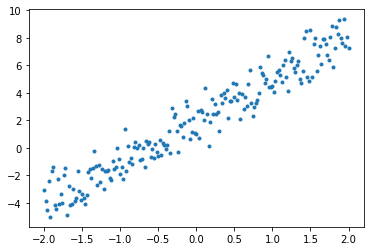

In [3]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

Tensors are usually gathered together in *batches*, or groups of inputs and outputs stacked together.  Batching can confer some training benefits and works well with accelerators and vectorized computation.  Given how small this dataset is, you can treat the entire dataset as a single batch.

## Define the model

Use `tf.Variable` to represent all weights in a model.  A `tf.Variable` stores a value and provides this in tensor form as needed.  See the [variable guide](./variable.ipynb) for more details.

Use `tf.Module` to encapsulate the variables and the computation.  You could use any Python object, but this way it can be easily saved.

Here, you define both *w* and *b* as variables.

In [4]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


The initial variables are set here in a fixed way, but Keras comes with any of a number of [initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) you could use, with or without the rest of Keras.

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Define the standard L2 loss, also known as the "mean squared" error:

In [5]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

* 注意，target_y, predicted_y 都是 vector

Before training the model, you can visualize the loss value by plotting the model's predictions in red and the training data in blue:

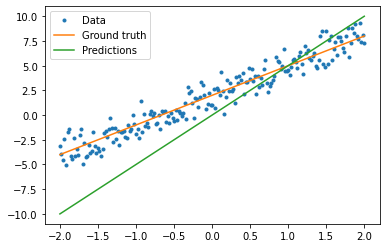

Current loss: 9.759627342224121


In [6]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print(f"Current loss: {loss(y, model(x)).numpy()}")
# print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### Define a training loop

The training loop consists of repeatedly doing three tasks in order:

* Sending a batch of inputs through the model to generate outputs
* Calculating the loss by comparing the outputs to the output (or label)
* Using gradient tape to find the gradients
* Optimizing the variables with those gradients

For this example, you can train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

There are many variants of the gradient descent scheme that are captured in `tf.keras.optimizers`. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines `tf.assign` and `tf.sub`):

In [9]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

For a look at training, you can send the same batch of *x* and *y* through the training loop, and see how `W` and `b` evolve.

In [10]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

Do the training

In [11]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=9.75963
Epoch  0:
     W = 4.48, b = 0.39, loss=6.05377
Epoch  1:
     W = 4.10, b = 0.71, loss=3.92840
Epoch  2:
     W = 3.83, b = 0.96, loss=2.69969
Epoch  3:
     W = 3.63, b = 1.16, loss=1.98354
Epoch  4:
     W = 3.48, b = 1.32, loss=1.56270
Epoch  5:
     W = 3.37, b = 1.45, loss=1.31337
Epoch  6:
     W = 3.29, b = 1.55, loss=1.16449
Epoch  7:
     W = 3.23, b = 1.63, loss=1.07491
Epoch  8:
     W = 3.19, b = 1.70, loss=1.02062
Epoch  9:
     W = 3.16, b = 1.75, loss=0.98750


Plot the evolution of the weights over time:

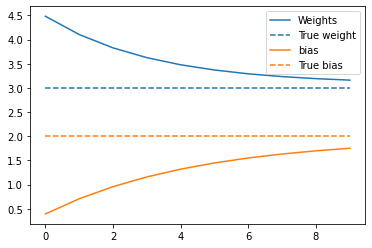

In [12]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

Visualize how the trained model performs

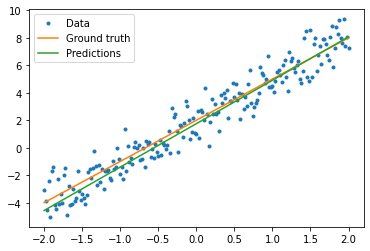

Current loss: 0.987504


In [13]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## The same solution, but with Keras

It's useful to contrast the code above with the equivalent in Keras.

Defining the model looks exactly the same if you subclass `tf.keras.Model`.  Remember that Keras models inherit ultimately from module.

In [14]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("keras_checkpoint")

Epoch  0:
     W = 4.48, b = 0.39, loss=6.05377
Epoch  1:
     W = 4.10, b = 0.71, loss=3.92840
Epoch  2:
     W = 3.83, b = 0.96, loss=2.69969
Epoch  3:
     W = 3.63, b = 1.16, loss=1.98354
Epoch  4:
     W = 3.48, b = 1.32, loss=1.56270
Epoch  5:
     W = 3.37, b = 1.45, loss=1.31337
Epoch  6:
     W = 3.29, b = 1.55, loss=1.16449
Epoch  7:
     W = 3.23, b = 1.63, loss=1.07491
Epoch  8:
     W = 3.19, b = 1.70, loss=1.02062
Epoch  9:
     W = 3.16, b = 1.75, loss=0.98750


Rather than write new training loops each time you create a model, you can use the built-in features of Keras as a shortcut.  This can be useful when you do not want to write or debug Python training loops.

If you do, you will need to use `model.compile()` to set the parameters, and `model.fit()` to train.  It can be less code to use Keras implementations of L2 loss and gradient descent, again as a shortcut.  Keras losses and optimizers can be used outside of these convenience functions, too, and the previous example could have used them.

In [15]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras `fit` expects batched data or a complete dataset as a NumPy array.  NumPy arrays are chopped into batches and default to a batch size of 32.

In this case, to match the behavior of the hand-written loop, you should pass `x` in as a single batch of size 1000.

In [16]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 9.7596
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 6.0538
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 3.9284
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 2.6997
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - loss: 1.9835
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 1.5627
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 1.3134
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 1.1645
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0749
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 1.0206


Note that Keras prints out the loss after training, not before, so the first loss appears lower, but otherwise this shows essentially the same training performance.

## Next steps

In this guide, you have seen how to use the core classes of tensors, variables, modules, and gradient tape to build and train a model, and further how those ideas map to Keras.

This is, however, an extremely simple problem. For a more practical introduction, see [Custom training walkthrough](../tutorials/customization/custom_training_walkthrough.ipynb).

For more on using built-in Keras training loops, see [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate).  For more on training loops and Keras, see [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).  For writing custom distributed training loops, see [this guide](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops).